<h3 style="margin-left:20px">Extended model v1 with  additional technical features- We choose the best features that gives us the lowest mean square error in the training set.
 
</h3>
 <ul class="list-group">
  <li class="list-group-item">Exponential Moving Average</li>
  <li class="list-group-item">Draw Down</li>
  <li class="list-group-item">Run Up</li>
  
  <li class="list-group-item">Random Feature</li>
  <li class="list-group-item">Bollinger Bands</li>
</ul>

<h4 style="margin-left:20px">If anyone of the above features gave a lower mean square accruacy 
    in our base set, it was added to the set of initial features otherwise the features were 
    discarded.
    
</h4>

<h4 style="color:red">A backtesting strategy is also added to check how our machine learning model would predict </h4>

In [1]:
import random
import csv
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import pandas as pd
import numpy as np
#import QSTK.qstkfeat.featutil as ftu
from pyalgotrade import strategy
from pyalgotrade import barfeed
from pyalgotrade import bar
from pyalgotrade.technical import ma as pytechma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.utils import stats as pytechstats
import datetime as dt
import os

In [2]:
# Change this to your directory structure

download_dir = '/Users/shadmanspc/Desktop/ADA/A2'

#'Specify the stock name in an array 

#Can do for any number of stocks just append the stock name in the stock array and download it
#it from a yahoo finance accordingly
#I took training from 2014-1-1 to 2018-12-31.

stocks = ['CBA.AX']

# keys from yahoo are different from what qstk library expects
#
yahoo_keys = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
qstk_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
#Keep track of the stocks and its data
raw_training_data = {}
# cloned for iteration, will remove those stocks from master stocks list if

# Initially designed for fetching direcrly from url but apparently everything has been deprecated.

stocks_clone = [s for s in stocks]

for s in stocks_clone:
    #Change the filename to stockname_training.csv
  
    file_name = download_dir + "/"+ s + '_training'+'.csv'
    print(file_name)
    if(os.path.isfile(file_name)) :
        raw_training_data[s] = pd.read_csv(file_name)
        
#I try to mimick the qstk library but this no longer available so I manipulate the data to my model
#to the way I believe qstk library would work
        

def sanitizedataforqstk(frame):
    data = {}
    for k in yahoo_keys:
        key_df = pd.DataFrame()
        for s in stocks:
            dates = np.array([dt.datetime.strptime(t, "%Y-%m-%d") for t in frame[s]['Date']])
            key_df[s] = pd.Series(data=frame[s][k].values, index=dates).sort_index(ascending=True)
        data[k] = key_df

    # sanitize to use the earlier keys
    data[qstk_keys[0]] = data[yahoo_keys[0]]
    data[qstk_keys[1]] = data[yahoo_keys[1]]
    data[qstk_keys[2]] = data[yahoo_keys[2]]
    data[qstk_keys[3]] = data[yahoo_keys[3]]
    data[qstk_keys[4]] = data[yahoo_keys[4]]
    data[qstk_keys[5]] = data[yahoo_keys[5]]
    del data[yahoo_keys[0]]
    del data[yahoo_keys[1]]
    del data[yahoo_keys[2]]
    del data[yahoo_keys[3]]
    del data[yahoo_keys[4]]
    del data[yahoo_keys[5]]
    for key in qstk_keys:
        data[key] = data[key].fillna(method='ffill')
        data[key] = data[key].fillna(method='bfill')
        data[key] = data[key].fillna(1.0)

    return data

training_data = sanitizedataforqstk(raw_training_data)
#print(training_data)

/Users/shadmanspc/Desktop/ADA/A2/CBA.AX_training.csv


In [3]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates moving average
def featMA( dData, lLookback=30, bRel=True, b_human=False ):
    '''
    @summary: Calculate moving average
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    
    dfPrice = dData['close']
    
    dfRet = dfPrice.rolling(lLookback).mean()
    #ts_log.rolling(12).mean()
    
    if bRel:
        dfRet = dfRet / dfPrice
    if b_human:  
        data2 = dfRet * dData['close']
        data3 = pand.DataFrame({"Raw":data2[data2.columns[0]]})
        for sym in dfRet.columns:
            if sym != '$SPX' and sym != '$VIX':
                data3[sym + " Moving Average"] = data2[sym]
                data3[sym] = dData['close'][sym]
        del data3['Raw']
        return data3
    return dfRet

ma_training=featMA(training_data,bRel=False).fillna(0.0)
#Filling not applicable values with mean instead of NA
#ma_training=rsi_training.fillna(ma_training['ASX.AX'].mean())

In [4]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates momentum

def returnize0(nds):
    """
    @summary Computes stepwise (usually daily) returns relative to 0, where
    0 implies no change in value.
    @return the array is revised in place
    """
    s= np.shape(nds)
    if len(s)==1:
        nds=np.expand_dims(nds,1)
    #print(s)
    nds[1:, :] = (nds[1:, :] - nds[0:-1]) / abs(nds[0:-1])
    nds[0, :] = np.zeros(nds.shape[1])
    
    #return nds

def featMomentum(dData, lLookback=20, b_human=False ):
    '''
    @summary: N day cumulative return (based on 1) indicator
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    if b_human:
        for sym in dData['close']:
            x=1000/dData['close'][sym][0]
            dData['close'][sym]=dData['close'][sym]*x
        return dData['close']
    dfPrice = dData['close'].copy()
    #print(dfPrice.values)
    
    #Calculate Returns
    returnize0(dfPrice.values)
    
    #Calculate rolling sum
    dfRet = dfPrice.rolling(lLookback).sum()
    #print(dfRet.head(100))
    
    
    return dfRet

mom_training=featMomentum(training_data).fillna(0.0)
#Filling not applicable values with mean instead of NA
#mom_training=rsi_training.fillna(mom_training['ASX.AX'].mean())
#print(mom_training.head(100))

In [5]:
# This code calculates RSI

def featRSI( dData, lLookback=14,  b_human=False):
    '''
    @summary: Calculate RSI
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past, 14 is standard
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''

    # create deltas per day
    delta = dData['close'].diff()
    #-----------
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(14).mean()
    RolDown = dDown.rolling(14).mean().abs()
    

    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

rsi_training=featRSI(training_data).fillna(0.0)
#Filling not applicable values with mean instead of NA
#rsi_training=rsi_training.fillna(rsi_training['ASX.AX'].mean())
#print(rsi_training.head(100))

In [6]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates exponential moving average

def featEMA( dData, lLookback=20, bRel=True,  b_human=False ):
    '''
    @summary: Calculate exponential moving average
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    
    dfPrice = dData['close']
    
    dfRet = dfPrice.ewm(span=lLookback).mean()
    
    if bRel:
        dfRet = dfRet / dfPrice;
    if b_human:  
        data2 = dfRet*dData['close']
        data3 = pand.DataFrame({"Raw":data2[data2.columns[0]]})
        for sym in dfRet.columns:
            if sym != '$SPX' and sym != '$VIX':
                data3[sym + " Moving Average"] = data2[sym]
                data3[sym] = dData['close'][sym]
        del data3['Raw']
        return data3          
    return dfRet

ema_training=featEMA(training_data,bRel=False).fillna(0.0)
#Filling not applicable values with mean instead of NA
#ema_training=ema_training.fillna(mom_training['ASX.AX'].mean())

In [7]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates drawDown

def featDrawDown( dData, lLookback=30,  b_human=False):
    '''
    @summary: Calculate Drawdown for the stock
    @param dData: Dictionary of data to use
    @param lLookback: Days to look back
    @return: DataFrame array containing values
    @param b_human: if true return dataframe to plot
    @warning: Drawdown and RunUp can depend heavily on sample period
    '''
    
    dfPrice = dData['close']
    
    #''' Feature DataFrame will be 1:1, we can use the price as a template '''
    dfRet = pd.DataFrame( index=dfPrice.index, columns=dfPrice.columns, data=np.zeros(dfPrice.shape) )
    
    dfMax = dfPrice.rolling(window=lLookback).max()
    
    return (dfMax - dfPrice) / dfMax;
    
    if b_human:
        for sym in dData['close']:
            x=1000/dData['close'][sym][0]
            dData['close'][sym]=dData['close'][sym]*x
        return dData['close']
    return dfRet

drawDown_training=featDrawDown(training_data).fillna(0.0)
#Filling not applicable values with mean instead of NA
#drawDown_training=drawDown_training.fillna(mom_training['ASX.AX'].mean())
#print(draw_training)

In [8]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates drawDown

def featRunUp( dData, lLookback=30, b_human=False ):
    '''
    @summary: CalculateRunup for the stock
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to calculate min over 
    @return: DataFrame array containing feature values
    @param b_human: if true return dataframe to plot
    @warning: Drawdown and RunUp can depend heavily on when the sample starts
    '''
    
    dfPrice = dData['close']
    
    dfMax = dfPrice.rolling(window=lLookback).min()
    return dfPrice / dfMax;
            
    if b_human:
        for sym in dData['close']:
            x=1000/dData['close'][sym][0]
            dData['close'][sym]=dData['close'][sym]*x
        return dData['close']
    return dfRet

runUp_training=featRunUp(training_data).fillna(0.0)
#Filling not applicable values with mean instead of NA
#runUp_training=runUp_training.fillna(mom_training['ASX.AX'].mean())


In [9]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates moving average
def featVolumeDelta( dData, lLookback=30, b_human=False ):
    '''
    @summary: Calculate moving average
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to use for MA
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    
    dfVolume = dData['volume']
    
    dfRet = dfVolume.rolling(lLookback).mean()
    dfRet /= dfVolume
        
    if b_human:
        for sym in dData['close']:
            x=1000/dData['close'][sym][0]
            dData['close'][sym]=dData['close'][sym]*x
        return dData['close']    
    return dfRet

volume_training=featVolumeDelta(training_data).fillna(0.0)
print(volume_training)
#Filling not applicable values with mean instead of NA
#volume_training=volume_training.fillna(mom_training['ASX.AX'].mean())

              CBA.AX
2014-01-02  0.000000
2014-01-03  0.000000
2014-01-06  0.000000
2014-01-07  0.000000
2014-01-08  0.000000
...              ...
2018-12-21  0.373038
2018-12-24  2.711589
2018-12-27  1.344552
2018-12-28  0.971788
2018-12-31  1.544736

[1266 rows x 1 columns]


In [10]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates moving average
def featRand( dData, b_human=False ):
    '''
    @summary: Random feature - used for robustness testing
    @param dData: Dictionary of data to use
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    
    dfPrice = dData['close']
    
    #''' Feature DataFrame will be 1:1, we can use the price as a template '''
    dfRet = pd.DataFrame( index=dfPrice.index, columns=dfPrice.columns, 
                            data=np.random.randn(*dfPrice.shape) )
    
    if b_human:
        for sym in dData['close']:
            x=1000/dData['close'][sym][0]
            dData['close'][sym]=dData['close'][sym]*x
        return dData['close']
    return dfRet

random_training=featRand(training_data).fillna(0.0)
#random_training=random_training.fillna(mom_training['ASX.AX'].mean())
#print(random_training)

In [11]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates moving average
def featBollinger( dData, lLookback=20, b_human=False ):
    '''
    @summary: Calculate bollinger position as a function of std deviations.
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to calculate moving average over
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing feature values
    '''
    if b_human:
        dfPrice = dData['close']
        nstdsRet = pd.DataFrame( index=dfPrice.index, columns=dfPrice.columns, data=np.zeros(dfPrice.shape) )
        #average minus standard deviation
        pstdsRet = pd.DataFrame( index=dfPrice.index, columns=dfPrice.columns, data=np.zeros(dfPrice.shape) )      
        data3 = pd.DataFrame({"Raw":dfPrice[dfPrice.columns[0]]})
        for sym in dfPrice.columns:
            if sym != '$SPX' and sym != '$VIX':
                tsPrice = dfPrice[sym]
                nstdRet = nstdsRet[sym]
                pstdRet = pstdsRet[sym]
                for i in range(len(tsPrice.index)):
                    if i < lLookback - 1:
                        nstdRet[i] = float('nan')
                        pstdRet[i] = float('nan')
                        continue    
                    fAvg = np.average( tsPrice[ i-(lLookback-1):i+1 ] )
                    fStd = np.std( tsPrice[ i-(lLookback-1):i+1 ] )
                    pstdRet[i] = fAvg+2.0*fStd
                    nstdRet[i] = fAvg-2.0*fStd  
                data3[sym] = dfPrice[sym]
                data3[sym + " Lower"] = nstdsRet[sym]
                data3[sym + " Upper"] = pstdsRet[sym]
        del data3['Raw']
        return data3
    else:
        dfPrice = dData['close']
        #''' Feature DataFrame will be 1:1, we can use the price as a template '''
        dfRet = pd.DataFrame( index=dfPrice.index, columns=dfPrice.columns, data=np.zeros(dfPrice.shape) )
        
        #''' Loop through stocks '''
        dfAvg = dfPrice.rolling(lLookback).mean()
        dfStd = dfPrice.rolling(lLookback).std()
        return (dfPrice - dfAvg) / (2.0*dfStd)
    
bollinger_training=featBollinger(training_data).fillna(0.0)
#bollinger_training=bollinger_training.fillna(bollinger_training['ASX.AX'].mean())

In [12]:
#If I want to predict the stock price for the next few days
#The current data set has values from 01/01/2019-today
currentDate = dt.date.today()
#YOu can take -30 as this dataset is relatively not needed however it must have 30 days as simple moving average has a lookback of 30 days
oldDate = currentDate + dt.timedelta(days=-30)
raw_current_data = {}
for s in stocks_clone:
    file_name = download_dir + "/"+ s + '_current'+'.csv'
    #print(file_name)
    if(os.path.isfile(file_name)) :
      
        raw_current_data[s] = pd.read_csv(file_name)
    

current_data = sanitizedataforqstk(raw_current_data)

In [13]:
#DEAP LIBRARY IS TAKEN

toolbox = base.Toolbox()
# basic initialization for deap
def initDeap():
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    # stochastic removed as High and Low can't be calculated for
    IND_SIZE = 6  
    # registerd coeff alias to coefficient function
    toolbox.register("coeffs", coefficient)
    # individual alias registerd to tools.initRepeat
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.coeffs, n=IND_SIZE)
    # population alias registered
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # evaluate fucntion registered to computeFitness function
    toolbox.register("evaluate", compute_fitness)
    toolbox.register("mate", tools.cxSimulatedBinary, eta=0.3)
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1.0, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=5)

# 1. rsi, 2. ma, 3. mom above is the order of coefficients removed pivot
# point and stochastic oscillator as one of the technical indicator, because
# lets say we are running this for the next 6 months,in that case we would
# not have the value of high, low of future. as such for future we can't use
# it.
def compute_fitness(individual):
    error = 0.0
    count = 0
    
    for key in stocks:
        # difference in RSI between day1 and day1 + 1
        rsidiff = rsi_training[key] - rsi_training[key].shift()
        # difference in moving average between day1 and day1 + 1
        madiff = ma_training[key] - ma_training[key].shift()
        # difference in momentum between day1 and day1 + 1
        momdiff = mom_training[key] - mom_training[key].shift()
        runUpdiff = runUp_training[key] - runUp_training[key].shift()
        drawDownDiff=drawDown_training[key]-drawDown_training[key].shift()
        bollingerDiff=bollinger_training[key]- bollinger_training[key].shift()
        #emaDiff=ema_training[key]- ema_training[key].shift()
        per_stock_count = 0
        dataframe_index = training_data[qstk_keys[3]][key].index.tolist()
        for (date, val) in rsi_training[key].iteritems():
            next_day = dataframe_index[per_stock_count + 1] if\
                per_stock_count <= len(dataframe_index) - 1 else None
            if not np.isnan(rsidiff[date]) and next_day is not None:
                #            Fitness defined as
                # market close (day2) - [ rsi difference between consecutive day * (coeff 1) +
                # moving average difference between consecutive day * (coeff 2) +
                # momentum difference between consecutive day * (coeff 3) +
                
                # Objective is to minimize the summation of squares of the above differences
                ft = (rsidiff[date]) * individual[0] + (madiff[date]) * individual[1] \
                     + (momdiff[date]) * individual[2]+ (runUpdiff[date]) * individual[3]+ (drawDownDiff[date]) * individual[4] \
                    + (bollingerDiff[date]) * individual[5]#+ (emaDiff[date]) * individual[6]
                ft = ft + training_data[qstk_keys[3]][key][date]
                error = error + np.square(training_data[qstk_keys[3]][key][next_day] - ft)
                count = count + 1
                per_stock_count = per_stock_count + 1
    # dividing by total count gives the mean square error, which we want to minimize
    #print("error")
    #print(error/count)
    return (error / count,)


def coefficient():
    return random.random()

In [14]:

#Get our base model up and Running
#Selecting the best set of features amongst the 9 features
#Start with a base model of two
#features available-
#bollinger_training,random_training,volume_training,runUp_training,drawDown_training,mom_training
#rsi_training,ma_training,ema_training


if __name__ == '__main__':
    
    bestFitness=10.0

    base_features=[ma_training,mom_training,rsi_training]
    base_featureString=["ma_training","mom_training","rsi_training"]

    features_bucket_left=[random_training,volume_training,runUp_training,drawDown_training,bollinger_training,
    ema_training]
    
    
    
    #=============#
    
    #random_training increased mean square error
    
    
    initDeap()
    # population generated
    #========================#
    #First pass we run our base Model
    pop = toolbox.population(n=80)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("std", np.std)
    stats.register("median", np.median)
    # built in algo used with cross over probability = 0.5, mutation probability = 0.2 and number of generation = 5
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.65, mutpb=0.35, ngen=11, stats=stats, halloffame=hof,
                                       verbose=True)
    features = ','.join(base_featureString)
    print("Best individual with feature-set: %s \nwith fitness: %s" % (features, hof[0].fitness))
    
    #maxErr=
    

gen	nevals	avg    	min     	max    	std    	median 
0  	80    	17.0465	0.251659	48.2226	13.9853	13.8766
1  	64    	4229.24	0.260235	170384 	26343.3	2.80913
2  	62    	22.7029	0.215322	745.169	113.56 	0.999094
3  	57    	0.984447	0.0919559	10.922 	1.82941	0.499551
4  	61    	3.55234 	0.0919559	121.54 	17.843 	0.294218
5  	58    	1.46988 	0.0441097	50.8142	6.63015	0.177059
6  	65    	0.732571	0.0240549	21.7881	2.67864	0.100149
7  	66    	1.18741 	0.00903321	73.7588	8.21532	0.0835872
8  	64    	1.49557 	0.00751101	81.4028	9.34736	0.0380729
9  	62    	0.0523054	0.00552764	0.81814	0.132046	0.0217212
10 	56    	1.16741  	0.00297923	89.3599	9.9239  	0.00903321
11 	67    	1.2989   	0.00197257	83.2842	9.31528 	0.00751101
Best individual with feature-set: ma_training,mom_training,rsi_training 
with fitness: (0.0019725720573645672,)


<table style="width:100%">
  <tr>
    <th>Features</th>
    <th>Mean Square Error</th> 
    
  </tr>
  <tr>
    <td>Simple Moving Average, RSI,Momentum</td>
    <td>0.0982</td> 
    
  </tr>
  <tr>
    <td>Simple Moving Average, RSI,Momentum,Random Indicator</td>
    <td>0.6101</td>
  </tr>
   <tr>
    <td>Simple Moving Average, RSI,Momentum,Run Up</td>
    <td>0.0309</td>
  </tr>
   <tr>
    <td>Simple Moving Average, RSI,Momentum,Run Up,Draw Down</td>
    <td>0.0303</td>
  </tr>
  <tr>
    <td>Simple Moving Average, RSI,Momentum,Run Up,Bollinger Bands</td>
    <td>0.0281</td>
  </tr>
  <tr>
    <td>Simple Moving Average, RSI,Momentum,Run Up,Bollinger Bands,Exponential Moving Average</td>
    <td>0.0291</td>
  </tr>
</table>

<h3 style="red"> From the above table the features; Simple Moving Average, RSI,Momentum,Run Up and the Bollinger Bands gave the lowest mean square error and would be taken for further investigation </h3>

In [15]:
def predict(individual, days=1):
    prediction_series= []
    for d in list(range(days)):
        # calculate the rsi, ma and momentum
        # with each preddiction the underluing current_data dataframe is updated,
        # so we get the updated rsi for all the days
        rsi_current = featRSI(current_data).fillna(0.0)
        #rsi_current=rsi_current.fillna(rsi_training['ASX.AX'].mean())
        
        ma_current = featMA(current_data, bRel=False).fillna(0.0)
        #ma_current=ma_current.fillna(ma_current['ASX.AX'].mean())
        
        mom_current = featMomentum(current_data)
        #mom_current=mom_current.fillna(mom_current['ASX.AX'].mean())
        
        runUp_current=featRunUp(current_data).fillna(0.0)
        #runUp_current=runUp_current.fillna(runUp_current['ASX.AX'].mean())
        
        drawDown_current=featDrawDown(current_data).fillna(0.0)
        #drawDown_current=drawDown_current.fillna(drawDown_current['ASX.AX'].mean())
        
        bollinger_current=featRunUp(current_data).fillna(0.0)
        #bollinger_current=bollinger_current.fillna(bollinger_current['ASX.AX'].mean())
        
       
        
        
        
        
        

        for key in stocks:
            # get the last valid date for which data is present
            last_date_with_data =\
                current_data[qstk_keys[3]][key].last_valid_index()
            #print("last-date")
            print(last_date_with_data)
            next_date = last_date_with_data + dt.timedelta(days=1)
            # calculate the rsi,ma and momentum diff across consecutive days 
            rsi_current_diff = rsi_current[key] - rsi_current[key].shift()
        # difference in moving average between day1 and day1 + 1
            ma_current_diff = ma_current[key] - ma_current[key].shift()
        # difference in momentum between day1 and day1 + 1
            mom_current_diff = mom_current[key] - mom_current[key].shift()
            runUp_current_diff = runUp_current[key] - runUp_current[key].shift()
            drawDown_current_diff=drawDown_current[key]-drawDown_current[key].shift()
            bollinger_current_diff=bollinger_current[key]- bollinger_current[key].shift()
            #print("mom_diff")
            #print(mom_current_diff)
            #  calculate the deviation based on the conefficients
            deviation = (rsi_current_diff.tail(1).values[0]) * individual[0]\
                + (ma_current_diff.tail(1).values[0]) * individual[1]+\
                (mom_current_diff.tail(1).values[0]) * individual[2]+\
                (runUp_current_diff.tail(1).values[0]) * individual[3]+\
                (drawDown_current_diff.tail(1).values[0]) * individual[4]+\
                (bollinger_current_diff.tail(1).values[0]) * individual[5]
            
                   
            print(deviation)
            # predicted is addition of deviation + current close
            predicted_close_next_day = deviation + current_data[qstk_keys[3]][key][last_date_with_data]
            # update the current dataframe so we can continue calculating stocks
            current_data[qstk_keys[3]][key].set_value(next_date,predicted_close_next_day)
            
            prediction_series.append((key,next_date,predicted_close_next_day,
                                      current_data[qstk_keys[3]][key][last_date_with_data] ,
                                      deviation))
    
    return prediction_series

2019-09-16 00:00:00
0.025027907561659467
2019-09-17 00:00:00
0.025027907561659467
2019-09-18 00:00:00
0.025027907561659467
movment: UP
predicted prices
09/17/2019- 81.71502990756167
movment: UP
predicted prices
09/18/2019- 81.74005781512334
movment: UP
predicted prices
09/19/2019- 81.765085722685
                Close
Date                 
2019-09-17  82.239998
2019-09-18  81.739998
2019-09-19  82.180000


/Users/shadmanspc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


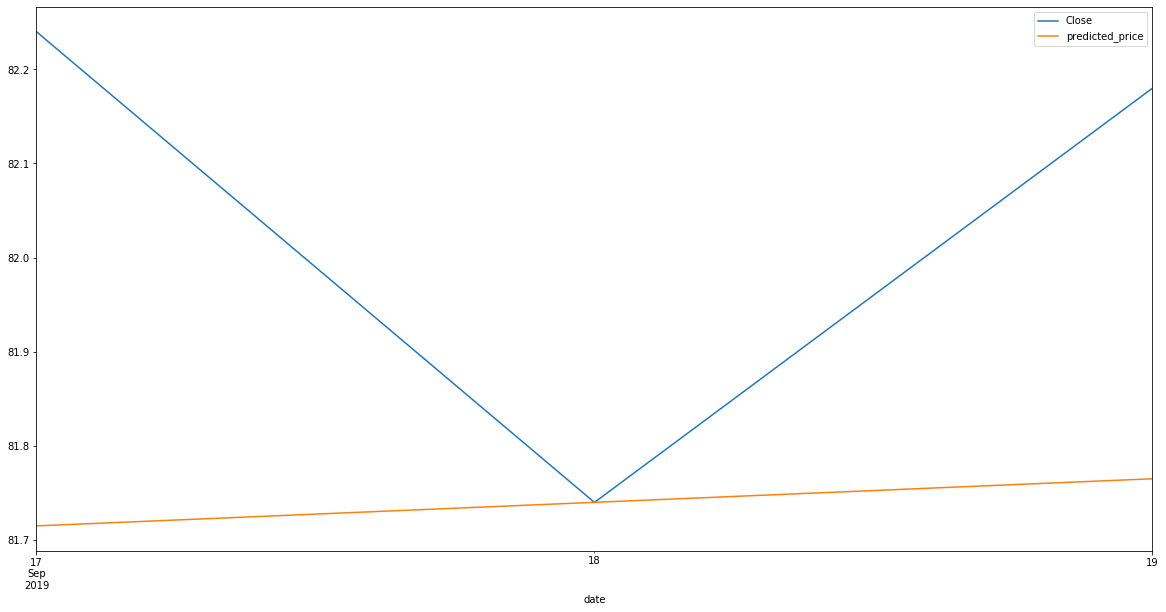

In [16]:
# predict for 5 days, change the number of days to get that many days of prediction
prediction_series = predict(hof[0],days=3)
# sorting the prediction series with all entries of same stock together
   
prediction_series_sorted = sorted(prediction_series, key=lambda tup: tup[0])
#print(prediction_series)
#print(stocks[0])

stockNames='-'.join(stocks)
    
filename = download_dir+'/results_predicted-'+stockNames+'ExtentedFeatures-.csv'
    #Store our testFileName

testFileName=download_dir+'/'+stocks[0]+'-Test.csv'
    #load our testFileName
test_file_name= pd.read_csv(testFileName)
closingPrices=test_file_name['Close']
    #print(closingPrices)
    #print("type")
    #print(type(closingPrices))
closingPrices=closingPrices.values.tolist()
    #print(closingPrices)
    #closingPrices=list(zip(closingPrices))
    

    #print(filename)
with open(filename, 'w') as csvfile:
        fieldnames = ['stock',
                      'date','actual_price','predicted_price','price_prev_day','deviation','movement']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        i=1
        #writer.writerow({'stock': stockNames , 'date': '16/09/2019','actual_price': closingPrices[0],'predicted_price': "Actual Price on 16th",'price_prev_day': "NA",'deviation':"NA",'movement':"NA"})
        for prediction in prediction_series_sorted:
            #Classify it as up or down
            movement = 'DOWN' if prediction[4] < 0 else 'UP'
            print("movment: "+movement)
            print("predicted prices")
            print(prediction[1].strftime('%m/%d/%Y')+"- %s" % prediction[2] )
            #print(closingPrices[i])
            writer.writerow(
                {'stock': prediction[0], 'date': prediction[1].strftime('%m/%d/%Y'),'predicted_price': prediction[2],'price_prev_day': prediction[3],'deviation':prediction[4],'movement':movement})
            i=i+1
            
predictedCSV=pd.read_csv(filename,usecols=(1,3),header = 0, index_col = 0,parse_dates=True, infer_datetime_format=True)

#print(testFileName)

actualCSV=pd.read_csv(testFileName,usecols=(0,4),header = 0, index_col = 0,parse_dates=True, infer_datetime_format=True)

    
print(actualCSV)

#print(current_data['close'])

#for predictedPrices in prediction_series_sorted
tryThis = actualCSV.plot(figsize=(20,10))
predictedCSV.plot(ax=tryThis)
    

<h3 style="red">Back Testing Strategy using pyalgotrade module </h3>

In [20]:
#get the current data frame again and change its name
raw_current_data = {}
for s in stocks_clone:
    file_name = download_dir + "/"+ s + '-backtesting'+'.csv'
    print(file_name)
    if(os.path.isfile(file_name)) :
      
        raw_current_data[s] = pd.read_csv(file_name)
    

verify_dataframe = sanitizedataforqstk(raw_current_data)
#print(verify_dataframe)

def predictVerify(individual, days=1):
    error = 0.0
    count = 0
    prediction_series = []

    verify_rsi_current = featRSI(current_data).fillna(0.0)
        #rsi_current=rsi_current.fillna(rsi_training['ASX.AX'].mean())
        
    verify_ma_current = featMA(current_data, bRel=False).fillna(0.0)
        #ma_current=ma_current.fillna(ma_current['ASX.AX'].mean())
        
    verify_mom_current = featMomentum(current_data).fillna(0.0)
        #mom_current=mom_current.fillna(mom_current['ASX.AX'].mean())
        
    verify_runUp_current=featRunUp(current_data).fillna(0.0)
        #runUp_current=runUp_current.fillna(runUp_current['ASX.AX'].mean())
        
    verify_drawDown_current=featDrawDown(current_data).fillna(0.0)
        #drawDown_current=drawDown_current.fillna(drawDown_current['ASX.AX'].mean())
        
    verify_bollinger_current=featRunUp(current_data).fillna(0.0)
    
    rsidiff=featRSI(training_data).fillna(0.0)
    

    for key in stocks:

        # difference in RSI between day1 and day1 + 1
        rsidiff = rsi_training[key] - rsi_training[key].shift()

        verify_rsi_current_diff = verify_rsi_current[key] - verify_rsi_current[key].shift()
        #verify_rsi_current_diff=verify_rsi_current_diff
        print(verify_rsi_current_diff)
        # difference in moving average between day1 and day1 + 1
        verify_ma_current_diff = verify_ma_current[key] - verify_ma_current[key].shift()
        # difference in momentum between day1 and day1 + 1
        verify_mom_current_diff = verify_mom_current[key] - verify_mom_current[key].shift()
        
        verify_runUp_current_diff = verify_runUp_current[key] - verify_runUp_current[key].shift()
        
        verify_drawDown_current_diff=verify_drawDown_current[key]-verify_drawDown_current[key].shift()
        #print(verify_drawDown_current_diff[key][date])
        verify_bollinger_current_diff=verify_bollinger_current[key]- verify_bollinger_current[key].shift()
        
        per_stock_count = 0
        
        verify_dataframe_indexes = verify_dataframe['close'][key].index.tolist()
        for (date, val) in verify_rsi_current[key].iteritems():
            next_day = (verify_dataframe_indexes[per_stock_count
                        + 1] if per_stock_count
                        <= len(verify_dataframe_indexes) - 1 else None)
            if not np.isnan(verify_rsi_current_diff[date]) and next_day is not None:
                #print("jer")
                #print(verify_rsi_current_diff[date])

                ft = (verify_rsi_current_diff[date] * individual[0]) + \
                     (verify_ma_current_diff[date] *  individual[1]) + \
                     (verify_mom_current_diff[date] * individual[2])+ \
                     (verify_runUp_current_diff[date] * individual[3])+ \
                     (verify_drawDown_current_diff[date] * individual[4])+ \
                     (verify_bollinger_current_diff[date] * individual[5])
                      
                    
                
                
                ft = ft + verify_dataframe['close'][key][date]
                prediction_series.append((key, next_day,
                        verify_dataframe['close'][key][next_day], ft,
                        verify_dataframe['close'][key][next_day] - ft))
                error = error + np.square(verify_dataframe['close'
                        ][key][next_day] - ft)

                # replacing the close price with the one predicted

                verify_dataframe['close'][key][next_day] = ft
                count = count + 1
                per_stock_count = per_stock_count + 1

    # dividing by total count gives the mean square error, which we wanted to minimize

    return (error / count, prediction_series)


prediction_series_verify = predictVerify(hof[0],days=5)
verify_dataframe['close']=verify_dataframe['close'].fillna(verify_dataframe['close'].mean())

#print("verfiy")
#print(verify_dataframe['close'])
#print("======")
#print(current_data)
verify_dataframeClose=verify_dataframe['open']
#print(type(verify_dataframe['ASX.AX']))

/Users/shadmanspc/Desktop/ADA/A2/ASX.AX-backtesting.csv
2019-08-05          NaN
2019-08-06     0.000000
2019-08-07     0.000000
2019-08-08     0.000000
2019-08-09     0.000000
2019-08-12     0.000000
2019-08-13     0.000000
2019-08-14     0.000000
2019-08-15     0.000000
2019-08-16     0.000000
2019-08-19     0.000000
2019-08-20     0.000000
2019-08-21     0.000000
2019-08-22     0.000000
2019-08-23    43.407529
2019-08-26     8.379999
2019-08-27    -4.643041
2019-08-28    -2.673911
2019-08-29    -3.113913
2019-08-30     5.256883
2019-09-02    -3.277021
2019-09-03    -2.436531
2019-09-04    11.201931
2019-09-05    -3.584726
2019-09-06     7.726122
2019-09-09    -8.647754
2019-09-10    -8.566235
2019-09-11    -6.305224
2019-09-12    -1.425758
2019-09-13    -0.863547
2019-09-16    -3.545569
Name: ASX.AX, dtype: float64


/Users/shadmanspc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
2018-11-01 00:00:00 strategy [INFO] BUY ASX.AX at $59.45
2018-11-02 00:00:00 strategy [INFO] SELL ASX.AX at $58.93
2018-12-31 00:00:00 strategy [INFO] BUY ASX.AX at $60.93
2019-01-03 00:00:00 strategy [INFO] SELL ASX.AX at $60.29
2019-01-04 00:00:00 strategy [INFO] BUY ASX.AX at $60.18
2019-03-26 00:00:00 strategy [INFO] SELL ASX.AX at $68.51
2019-04-01 00:00:00 strategy [INFO] BUY ASX.AX at $69.88
2019-04-02 00:00:00 strategy [INFO] SELL ASX.AX at $70.14
2019-04-03 00:00:00 strategy [INFO] BUY ASX.AX at $70.50
2019-05-31 00:00:00 strategy [INFO] SELL ASX.AX at $75.02
2019-06-03 00:00:00 strategy [INFO] BUY ASX.AX at $75.27
2019-06-04 00:00:00 strategy [INFO] SELL ASX.AX at $7

Final portfolio value for stock ASX.AX : $100071.05
Anual return: 0.07 %
Annualized Sharpe ratio: 0.40


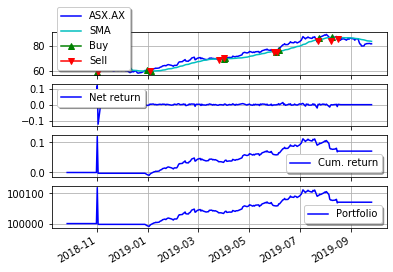

Total portfolio value: 100071.05001000004


In [22]:
class TradingStrategy(strategy.BacktestingStrategy):

    # default period to calculate moving avg is 14 , cash = 100000

    def __init__(
        self,
        barFeed,
        instrument,
        smaPeriod=26,
        cash_or_brk=100000,
        ):
        strategy.BacktestingStrategy.__init__(self, barFeed,
                cash_or_brk)
        self.__position = None
        self.__instrument = instrument
        self.__sma = \
            pytechma.SMA(barFeed[instrument].getPriceDataSeries(),
                         smaPeriod)

    # for every day , we decide using this function if we need to buy or sell.
    # currently we simply see if the closing price > moving average, we buy, else we sell

    def onBars(self, bars):

        # Wait for enough bars to be available to calculate a SMA.

        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]

        # If a position was not opened, check if we should enter a long position.

        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:

                # Enter a buy market order for 5 shares. The order is good till canceled.

                self.__position = self.enterLong(self.__instrument, 5,
                        True)
        elif bar.getPrice() < self.__sma[-1] \
            and not self.__position.exitActive():

        # Check if we have to exit the position.

            self.__position.exitMarket()

    # this function are called when the order submitted to enter a position was filled

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        #print("BUY")
        
        self.info('BUY %s at $%.2f' % (self.__instrument,execInfo.getPrice()))
        
        #print("===========")

    def onEnterCanceled(self, position):
        self.__position = None

    # this function are called when the exit order for a position was filled

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        #print("SELL")
        
        self.info("SELL %s at $%.2f" % (self.__instrument,execInfo.getPrice()))
        
        #print("===========")
        self.__position = None

    def onExitCanceled(self, position):

        # If the exit was canceled, re-submit it.

        self.__position.exitMarket()

    # if we are using other indicators as well, then we can define fcuntions to expose the data series here

    def getSMA(self):
        return self.__sma


# class representing bar

class DataframeBar(bar.Bar):

    def __init__(
        self,
        dateTime,
        open_,
        high,
        low,
        close,
        volume,
        adjClose,
        frequency,
        ):
        self.__dateTime = dateTime
        self.__open = open_
        self.__close = close
        self.__high = high
        self.__low = low
        self.__volume = volume
        self.__adjClose = adjClose
        self.__frequency = frequency
        self.__useAdjustedValue = False

    def setUseAdjustedValue(self, useAdjusted):
        if useAdjusted and self.__adjClose is None:
            raise Exception('Adjusted close is not available')
        self.__useAdjustedValue = useAdjusted

    def getUseAdjValue(self):
        return self.__useAdjustedValue

    def getDateTime(self):
        return self.__dateTime

    def getOpen(self, adjusted=False):
        if adjusted:
            if self.__adjClose is None:
                raise Exception('Adjusted close is missing')
            return self.__adjClose * self.__open / float(self.__close)
        else:
            return self.__open

    def getHigh(self, adjusted=False):
        if adjusted:
            if self.__adjClose is None:
                raise Exception('Adjusted close is missing')
            return self.__adjClose * self.__high / float(self.__close)
        else:
            return self.__high

    def getLow(self, adjusted=False):
        if adjusted:
            if self.__adjClose is None:
                raise Exception('Adjusted close is missing')
            return self.__adjClose * self.__low / float(self.__close)
        else:
            return self.__low

    def getClose(self, adjusted=False):
        if adjusted:
            if self.__adjClose is None:
                raise Exception('Adjusted close is missing')
            return self.__adjClose
        else:
            return self.__close

    # These are helper functions to get the prices

    def getVolume(self):
        return self.__volume

    def getAdjOpen(self):
        return self.getOpen(True)

    def getAdjHigh(self):
        return self.getHigh(True)

    def getAdjLow(self):
        return self.getLow(True)

    def getAdjClose(self):
        return self.__adjClose

    def getFrequency(self):
        return self.__frequency

    def getPrice(self):
        if self.__useAdjustedValue:
            return self.__adjClose
        else:
            return self.__close


# class representing a barfeed, created from a panda dataframe

class DataFrameFeed(barfeed.BaseBarFeed):

    def __init__(
        self,
        dataframe,
        instrument,
        frequency,
        ):
        super(DataFrameFeed, self).__init__(frequency)
        self.registerInstrument(instrument)
        self.__df = dataframe
        self.__instrument = instrument
        self.__next = 0

    def reset(self):
        super(DataFrameFeed, self).reset()
        self.__next = 0

    def peekDateTime(self):
        return self.getCurrentDateTime()

    def getCurrentDateTime(self):
        ret = None
        if not self.eof():
            rowkey = self.__df.index.tolist()[self.__next]
            #print(rowkey.to_pydatetime())
            ret = rowkey.to_pydatetime()
            #print(ret)
        return ret

    def barsHaveAdjClose(self):
        return True

    def getNextBars(self):
        ret = None
        if not self.eof():
            rowkey = self.__df.index.tolist()[self.__next]
            row = self.__df.ix[rowkey]
            #print(row[0])
            bar_dict = {self.__instrument: DataframeBar(
                rowkey.to_pydatetime(),
                row[qstk_keys[0]],
                row[qstk_keys[1]],
                row[qstk_keys[2]],
                row[qstk_keys[3]],
                row[qstk_keys[4]],
                row[qstk_keys[5]],
                self.getFrequency(),
                )}
            ret = bar.Bars(bar_dict)
            self.__next += 1
        return ret

    def eof(self):
        return self.__next >= len(self.__df.index)

    def start(self):
        pass

    def stop(self):
        pass

    def join(self):
        pass


# class defining % returns for cumulative and net

class PercentageReturns(returns.Returns):

    def __init__(self):
        super(PercentageReturns, self).__init__()

    def beforeAttach(self, strat):

        # Get or create a shared ReturnsAnalyzerBase

        analyzer = returns.ReturnsAnalyzerBase.getOrCreateShared(strat)
        analyzer.getEvent().subscribe(self.__onReturns)

    def __onReturns(self, dateTime, returnsAnalyzerBase):

        # multiplying by 100 gives us the percentage, weird I know, but the examples of pyalgotrade seems to say this

        super(PercentageReturns,
              self).getReturns().append(returnsAnalyzerBase.getNetReturn()
                * 100)
        super(PercentageReturns,
              self).getCumulativeReturns().append(returnsAnalyzerBase.getCumulativeReturn()
                * 100)


# for each stocks we are running our strategy

total_portfolio_value = 0
for key in stocks:
    data_stock = {
        'open': verify_dataframe['open'][key],
        'high': verify_dataframe['high'][key],
        'low': verify_dataframe['low'][key],
        'close': verify_dataframe['close'][key],
        'volume': verify_dataframe['volume'][key],
        'actual_close': verify_dataframe['actual_close'][key],
        }

    # creating a dataframe as expected by dataframefeed

    df = pd.DataFrame(data_stock)  # create a dataframe feed with frequncy daily
    feed = DataFrameFeed(df, key, barfeed.Frequency.DAY)

    # the startegy for each stock with deafult cash_or_brk = 100000

    investing = 100000
    tstrategy = TradingStrategy(feed, key, cash_or_brk=investing)
    returnsAnalyzer = PercentageReturns()
    tstrategy.attachAnalyzer(returnsAnalyzer)

    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    tstrategy.attachAnalyzer(sharpeRatioAnalyzer)

    # Attach the plotter to the strategy.

    plt = plotter.StrategyPlotter(tstrategy)

    # Include the SMA in the instrument's subplot to get it displayed along with the closing prices.
    # if other techinical indicators are used, add those data series here

    plt.getInstrumentSubplot(key).addDataSeries('SMA',
            tstrategy.getSMA())

    # Plot the strategy returns at each bar.

    plt.getOrCreateSubplot('net/daily returns'
                           ).addDataSeries('Net return',
            returnsAnalyzer.getReturns())
    plt.getOrCreateSubplot('cum. returns').addDataSeries('Cum. return',
            returnsAnalyzer.getCumulativeReturns())

    tstrategy.run()
    total_portfolio_value = total_portfolio_value \
        + tstrategy.getResult()
    print ('Final portfolio value for stock %s : $%.2f' % (key,tstrategy.getResult()))
    
    print ('Anual return: %.2f %%' % returnsAnalyzer.getCumulativeReturns()[-1]) 
    print ('Annualized Sharpe ratio: %.2f' % sharpeRatioAnalyzer.getSharpeRatio(0, annualized=True))
    plt.plot()
    
   

print ('Total portfolio value: %s' % total_portfolio_value)